In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

/Users/clawsy/Documents/geoelements_dev/xai-cpt/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_path = 'data'
model_path = 'model'
output_path = 'output'

In [3]:
ic_data = np.load(f'{data_path}/ic_5cm_v3.npy')
qc_data = np.load(f'{data_path}/qc_5cm_v3.npy')
id_data = np.load(f'{data_path}/id_5cm_v3.npy')

mask = np.alltrue(ic_data<=5, axis=1)
id_data = id_data[mask]
ic_data = ic_data[mask]
qc_data = qc_data[mask]
print(ic_data.shape)
print(qc_data.shape)

(12475, 200)
(12475, 200)


In [4]:
which = 'ic'
if which == 'ic':
  vmax = 5
  scale = 5
  X = ic_data.reshape(-1,10,20)/scale
elif which == 'qc':
  vmax = 254
  scale = 254
  X = qc_data.reshape(-1,10,20)/scale
else:
  X = np.stack((ic_data/5, qc_data/254),axis=1)
# split data into 80-20 of training and testing set
X_train, X_valid_test = train_test_split(X, test_size=0.3, random_state=0)
X_valid, X_test = train_test_split(X_valid_test, test_size=0.5, random_state=0)

In [5]:
# create depth array
depth = np.linspace(0,10,200)

10 20


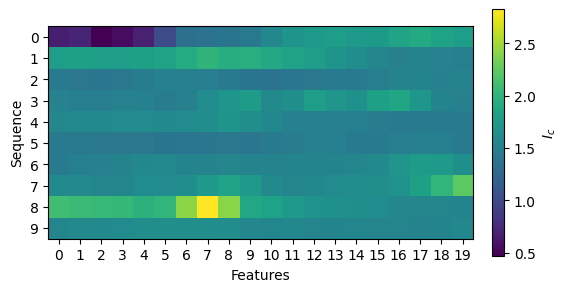

In [6]:
# demo of reshaping CPT profile
n_seq = X_train.shape[-2]
d_model = X_train.shape[-1]
print(n_seq, d_model)

fig, ax = plt.subplots(figsize=(6,8))
im = plt.imshow(X_train[0]*scale)
plt.colorbar(mappable=im, ax=ax,fraction=0.046, pad=0.04,shrink=0.4,label='$I_c$')
plt.ylabel('Sequence')
plt.xlabel('Features')
plt.xticks(np.arange(d_model))
plt.yticks(np.arange(n_seq))
plt.savefig(f'{output_path}/reshaped_ic.png',dpi=200)
plt.show()

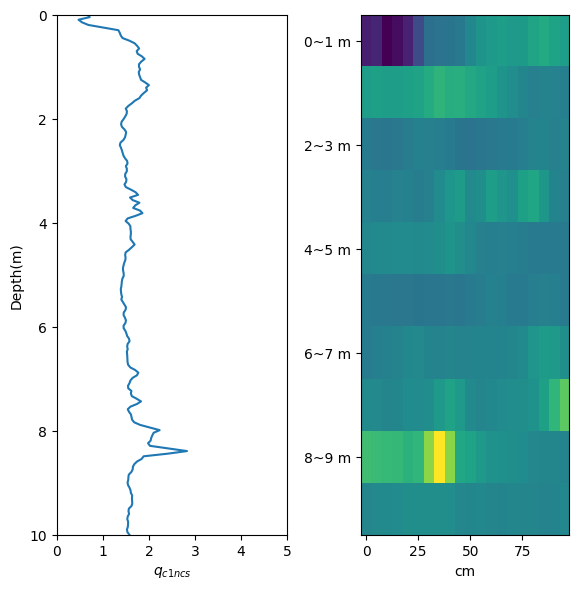

In [7]:
# demo2 of reshaping CPT profile
fig, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].plot(X_train[0].reshape(-1)*scale,depth)
ax[0].set_xlim(0,vmax)
ax[0].set_ylim(10,0)
ax[0].set_xlabel('$q_{c1ncs}$')
ax[0].set_ylabel('Depth(m)')
ax[1].imshow(X_train[0])
ax[1].set_aspect(5)
ax[1].set_yticks([0,2,4,6,8],['0~1 m','2~3 m','4~5 m','6~7 m','8~9 m'])
#ax[1].set_yticklabels()
ax[1].set_xticks([0,5,10,15],[0,25,50,75])
ax[1].set_xlabel('cm')
plt.tight_layout()

## Self-attention AE

In [8]:
# set up seed
np.random.seed(0)
tf.random.set_seed(0)

In [9]:
# positional encoding
def positional_encoding(length, depth):
  scale=1
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)*scale
  return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
# define sampling if using variational autoencoder
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]),
                              mean=0., stddev=0.1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

(10, 20)


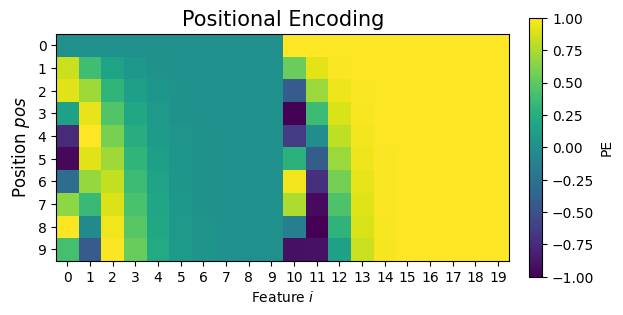

In [11]:
# demo of positional encoding
n_seq = X_train.shape[-2]
d_model = X_train.shape[-1]
# plot positional encoding
pos_code = positional_encoding(n_seq,d_model).numpy()
#pos_code = pos_code[:n_seq,:d_model]
im = plt.imshow(pos_code, vmin=-1)
print(pos_code.shape)
plt.ylabel('Position $pos$', fontsize=12)
plt.xlabel('Feature $i$')
plt.xticks(np.arange(d_model))
plt.yticks(np.arange(n_seq))
plt.title('Positional Encoding', fontsize=15)
plt.colorbar(im,fraction=0.046, pad=0.04,shrink=0.7,label='PE')
plt.show()

In [12]:
# define the model, we only use one AT block for encoder and decoder
def make_SAE(latent_dim, initial_heads=1, intermediate_heads=1, vari=False, reconstr_factor=1):
  #keras.backend.clear_session()

  # Create encoder
  inputs = keras.Input(shape=(n_seq, d_model), name='enc_input')

  pos_code = positional_encoding(n_seq,d_model)
  x = inputs + pos_code
  # encoder attention block 1
  enc_at1, w = keras.layers.MultiHeadAttention(num_heads=initial_heads, key_dim=d_model, dropout=0.1, name='enc_at1')(x, x, return_attention_scores=True)
  x = keras.layers.Add()([inputs, enc_at1])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  '''
  # encoder attention block 2
  enc_at2 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, dropout=0.1, name='enc_at2')(x, x)
  x = keras.layers.Add()([x, enc_at2])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

  # encoder attention block 3
  enc_at3 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, dropout=0.1, name='enc_at3')(x, x)
  x = keras.layers.Add()([x, enc_at3])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

  # encoder attention block 4
  enc_at4 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, dropout=0.1, name='enc_at4')(x, x)
  x = keras.layers.Add()([x, enc_at4])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)'''

  x = keras.layers.Flatten()(x)
  if vari:
    z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
    #z = Sampling()([z_mean, z_log_var])
    z = keras.layers.Lambda(sampling)([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  else:
    latent = keras.layers.Dense(latent_dim)(x)
    encoder = keras.Model(inputs, latent, name='encoder')
  # Create decoder
  latent_inputs = keras.Input(shape=(latent_dim,), name='dec_input')

  x = keras.layers.Dense(n_seq*d_model)(latent_inputs)
  x = keras.layers.Reshape((n_seq,d_model), name='reshape')(x)

  '''# decoder attention block 1
  dec_at1 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, name='dec_at1')(x, x)
  x = keras.layers.Add()([x, dec_at1])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  # decoder attention block 2
  dec_at2 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, name='dec_at2')(x, x)
  x = keras.layers.Add()([x, dec_at2])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  # decoder attention block 3
  dec_at3 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, name='dec_at3')(x, x)
  x = keras.layers.Add()([x, dec_at3])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)'''
  # decoder attention block 4
  dec_at4 = keras.layers.MultiHeadAttention(num_heads=intermediate_heads, key_dim=d_model, name='dec_at4')(x, x)
  x = keras.layers.Add()([x, dec_at4])
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  dense = keras.layers.Dense(256, activation='relu')(x)
  dense = keras.layers.Dense(d_model)(dense)
  x = keras.layers.Add()([x , dense])
  outputs = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  #outputs = keras.layers.Activation('relu')(x) # or relu

  decoder = keras.Model(latent_inputs, outputs, name='decoder')

  # instantiate SAE model
  if vari:
    outputs = decoder(encoder(inputs)[2])
    sae = keras.Model(inputs, outputs, name='sae')

    reconstruction_loss = keras.losses.mse(inputs, outputs)
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstr_factor*reconstruction_loss + 0.0001*kl_loss

    sae.add_loss(total_loss)
    sae.compile(optimizer='adam') # adam, SGD
  else:
    outputs = decoder(encoder(inputs))
    sae = keras.Model(inputs, outputs, name='sae')
    sae.compile(optimizer='adam', loss='mse')
  return encoder, decoder, sae

## Training

In [13]:
# define training hyperparameters
vari = False
reconstr_factor = 1
latent_dim = 10

original_dim = n_seq * d_model
initial_heads = 3
intermediate_heads = 5
epochs = 400

In [14]:
import random
tf.keras.backend.clear_session()
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
# create model
enc, dec, sae = make_SAE(latent_dim=latent_dim, initial_heads=initial_heads,intermediate_heads=intermediate_heads, vari=vari, reconstr_factor=reconstr_factor)
sae.summary()

Model: "sae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 10, 20)]          0         
                                                                 
 encoder (Functional)        (None, 10)                17606     
                                                                 
 decoder (Functional)        (None, 10, 20)            21116     
                                                                 
Total params: 38722 (151.26 KB)
Trainable params: 38722 (151.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# fit model
fit_sae = sae.fit(X_train, X_train,
        epochs=epochs,
        batch_size=128,
        validation_data=(X_valid, X_valid),
        verbose=2)

Epoch 1/400
69/69 - 1s - loss: 1.0105 - val_loss: 0.8665 - 1s/epoch - 22ms/step
Epoch 2/400
69/69 - 1s - loss: 0.7446 - val_loss: 0.6223 - 730ms/epoch - 11ms/step
Epoch 3/400
69/69 - 1s - loss: 0.5241 - val_loss: 0.4321 - 817ms/epoch - 12ms/step
Epoch 4/400
69/69 - 1s - loss: 0.3655 - val_loss: 0.3036 - 816ms/epoch - 12ms/step
Epoch 5/400
69/69 - 1s - loss: 0.2578 - val_loss: 0.2146 - 811ms/epoch - 12ms/step
Epoch 6/400
69/69 - 1s - loss: 0.1820 - val_loss: 0.1511 - 815ms/epoch - 12ms/step
Epoch 7/400
69/69 - 1s - loss: 0.1278 - val_loss: 0.1056 - 815ms/epoch - 12ms/step
Epoch 8/400
69/69 - 1s - loss: 0.0890 - val_loss: 0.0733 - 812ms/epoch - 12ms/step
Epoch 9/400
69/69 - 1s - loss: 0.0617 - val_loss: 0.0507 - 819ms/epoch - 12ms/step
Epoch 10/400
69/69 - 1s - loss: 0.0427 - val_loss: 0.0352 - 824ms/epoch - 12ms/step
Epoch 11/400
69/69 - 1s - loss: 0.0298 - val_loss: 0.0248 - 818ms/epoch - 12ms/step
Epoch 12/400
69/69 - 1s - loss: 0.0213 - val_loss: 0.0181 - 811ms/epoch - 12ms/step
Epoc

In [32]:
# save model
# sae.save(f'{model_path}/sae_{which}_lat{latent_dim}.h5')
# enc.save(f'{model_path}/enc_{which}_lat{latent_dim}.h5')
# dec.save(f'{model_path}/dec_{which}_lat{latent_dim}.h5')

In [ ]:
# load model
sae = keras.models.load_model(f'{model_path}/sae_{which}_lat{latent_dim}.h5')
dec = keras.models.load_model(f'{model_path}/dec_{which}_lat{latent_dim}.h5')
enc = keras.models.load_model(f'{model_path}/enc_{which}_lat{latent_dim}.h5')

# Results

Text(0.5, 1.0, 'output/training history of self-attention AE')

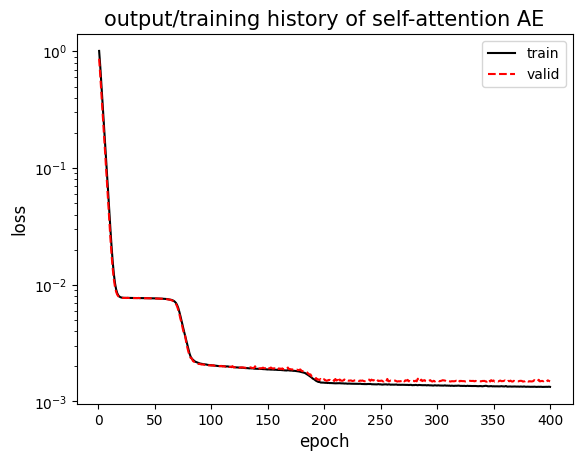

In [16]:
# loss history
plt.plot(np.arange(1,epochs+1),fit_sae.history['loss'], 'k-', label='train')
plt.plot(np.arange(1,epochs+1),fit_sae.history['val_loss'], 'r--', label='valid')
plt.xlabel('epoch',fontsize=12)

plt.ylabel('loss',fontsize=12)
plt.yscale('log')
plt.legend()
plt.title(f'{output_path}/training history of self-attention AE',fontsize=15)

Text(0, 0.5, 'Counts')

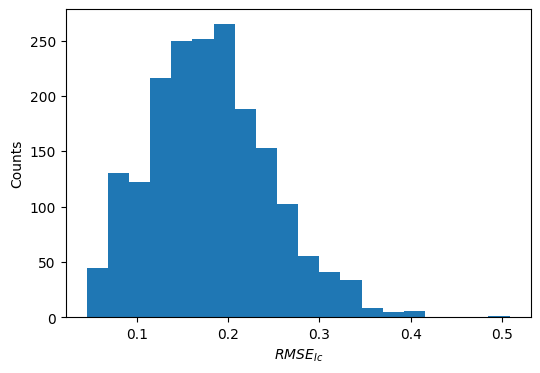

In [17]:
# reconstruction errors
reconstr = (sae.predict(X_test, verbose=0)).reshape(-1,200)
rmse_ic = np.sqrt(np.mean((vmax*(X_test.reshape(-1,200) - reconstr))**2, axis=1))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(rmse_ic, bins=20)
ax.set_xlabel('$RMSE_{Ic}$')
ax.set_ylabel('Counts')
#ax[0].set_xlim(0,1)

In [18]:
dataset = X_test
#preds = sae.predict(dataset, verbose=0)
index = 0

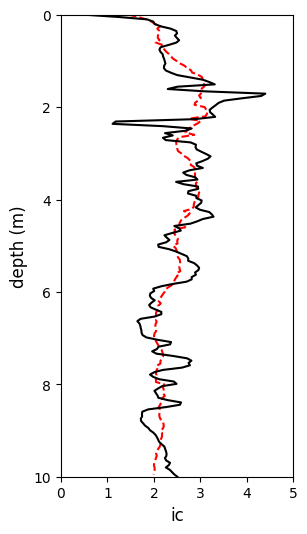

In [19]:
if which == 'both':
  fig, ax = plt.subplots(1,2,figsize=(6,6))
  pred = sae.predict(dataset[index:index+1], verbose=0).squeeze(axis=0)
  ax[0].plot(pred[:,0]*5, np.arange(0,10,0.05),'r--')
  ax[0].plot(dataset[index,:,0]*5, np.arange(0,10,0.05),'k-')
  ax[1].plot(pred[:,1]*254, np.arange(0,10,0.05),'r--')
  ax[1].plot(dataset[index,:,1]*254, np.arange(0,10,0.05),'k-')

else:
  plt.figure(figsize=(3,6))
  pred = sae.predict(dataset[index:index+1], verbose=0)
  plt.plot(pred.reshape(-1)*scale,np.arange(0,10,0.05),'r--')
  plt.plot(dataset[index].reshape(-1)*scale, np.linspace(0,10,200), 'k-')
  plt.xlabel(which, fontsize=12)
  plt.ylabel('depth (m)', fontsize=12)
  plt.ylim(10,0)
  plt.xlim(0,vmax)
index += 1

## Visualize attention score of the first attention layer

In [20]:
dataset = X_test
attention = keras.Model(inputs=enc.inputs, outputs=enc.get_layer('enc_at1').output)
at_score = attention.predict(dataset, verbose=0)
at_score[1].shape

(1872, 3, 10, 10)

In [21]:
index = 0
cmap = 'inferno'
at_index = 1

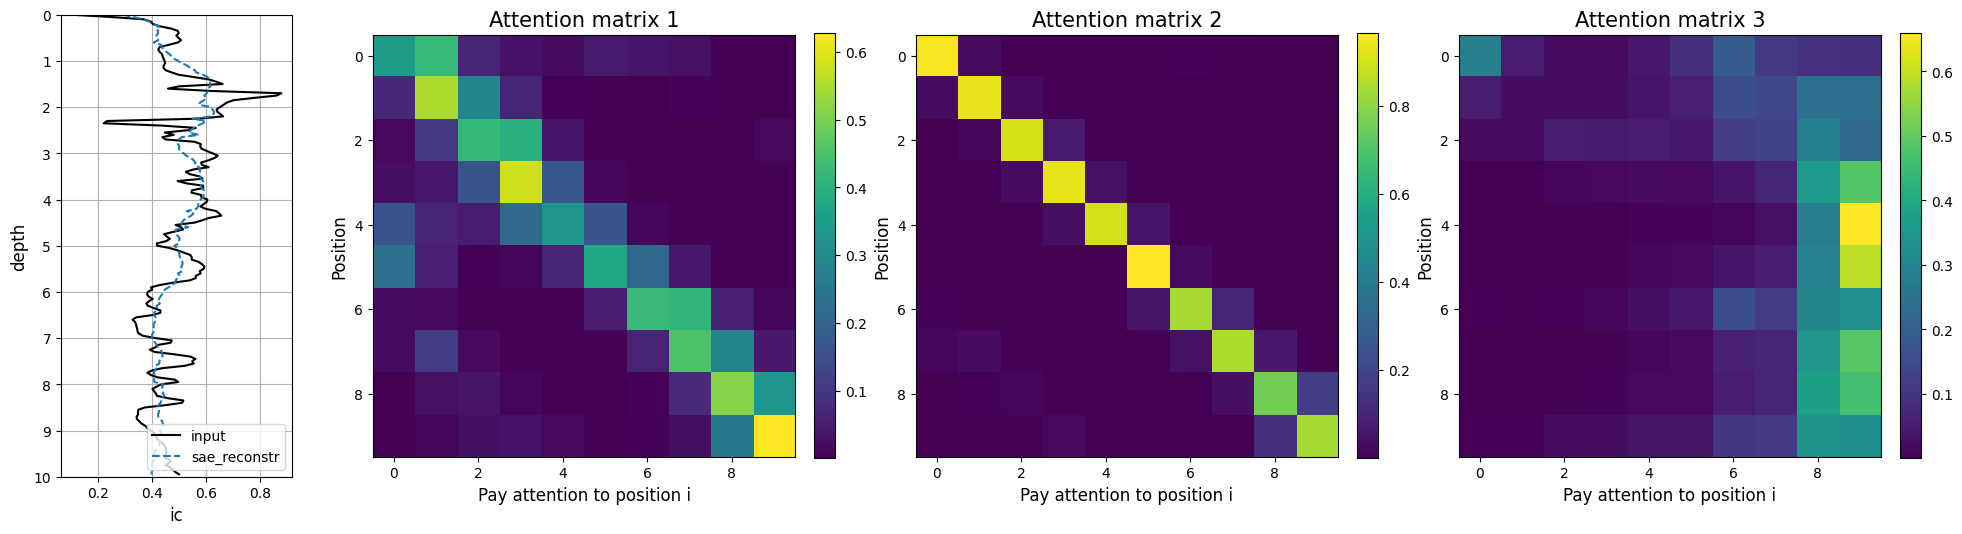

In [22]:
from matplotlib import gridspec
#fig, ax = plt.subplots(1,3, figsize=(18,6))
fig = plt.figure(figsize=(6*(initial_heads+1), 6))
width_ratios = np.ones(initial_heads+1)
width_ratios[1:] = 2
gs = gridspec.GridSpec(1, initial_heads+1, width_ratios=width_ratios)
im_ratio = 200

input = dataset[index].reshape(-1)

reconstr = sae.predict(dataset[index:index+1], verbose=0).reshape(-1)
ax0 = plt.subplot(gs[0])
ax0.plot(input, np.linspace(0,10,200,endpoint=False),'k', label='input')
#cae_reconstr = cae.predict(input.reshape(1,200))
#ax0.plot(cae_reconstr.reshape(-1), np.linspace(0,10,200,endpoint=False), label='cae_reconstr', linestyle='--')
ax0.plot(reconstr, np.linspace(0,10,200,endpoint=False), label='sae_reconstr', linestyle='--')
ax0.set_ylabel('depth',fontsize=12)
ax0.set_xlabel(which,fontsize=12)
ax0.set_ylim(10,0)
#ax0.set_xlim(0,4)
ax0.set_yticks(np.linspace(0,11,11,endpoint=False))
ax0.grid()
ax0.legend()

for i in range(initial_heads):
  # attention matrix 1
  ax1 = plt.subplot(gs[i+1])
  im1 = ax1.imshow(at_score[1][index][i], cmap='viridis')
  ax1.set_xlabel('Pay attention to position i',fontsize=12)
  ax1.set_ylabel('Position',fontsize=12)
  plt.colorbar(im1, fraction=0.046*1,pad=0.04, ax=ax1)
  ax1.set_title(f'Attention matrix {i+1}',fontsize=15)
#plt.tight_layout()
index += 1